# Comparing Feedforward neural network vs Basic Convolutional neural network on image data

## Dataset:
The CIFAR-10 dataset (Canadian Institute for Advanced Research, 10 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class.

The criteria for deciding whether an image belongs to a class were as follows:

    The class name should be high on the list of likely answers to the question “What is in this picture?”
    The image should be photo-realistic. Labelers were instructed to reject line drawings.
    The image should contain only one prominent instance of the object to which the class refers. The object may be partially occluded or seen from an unusual viewpoint as long as its identity is still clear to the labeler.

Source:
https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

In [2]:
(X_train_orig,Y_train_orig),(X_test_orig,Y_test_orig) = cifar10.load_data()
X_train_orig.shape, Y_train_orig.shape
X_train, X_val, Y_train, Y_val = train_test_split(X_train_orig, Y_train_orig,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=Y_train_orig)

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
X_train = X_train/255
X_val = X_val/255
X_test = X_test_orig/255
X_train_flatten = X_train.reshape(X_train.shape[0],32*32*3)
X_val_flatten = X_val.reshape(X_val.shape[0],32*32*3)
X_test_flatten = X_test.reshape(X_test.shape[0],32*32*3)

In [4]:
loss = 'sparse_categorical_crossentropy'
metrics=['accuracy']

## Shallow Feedforward Neural Network
Let's begin with a basic FFN with only two hidden layers and no regularization.


In [5]:
fnn_shallow = tf.keras.models.Sequential([
    tfl.Input(shape=(X_train_flatten.shape[1],)),
    tfl.Dense(units=32, activation='relu'),
    tfl.Dense(units=10, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
fnn_shallow.compile(loss=loss, optimizer=optimizer, metrics=metrics)
fnn_shallow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                98336     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 98666 (385.41 KB)
Trainable params: 98666 (385.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
history = fnn_shallow.fit(X_train_flatten, Y_train,
                  epochs=50,
                  batch_size=64,
                  validation_data=(X_val_flatten, Y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 2.0724 - accuracy: 0.2558 - val_loss: 1.9291 - val_accuracy: 0.3241
Epoch 2/50
625/625 [==============================] - 3s 4ms/step - loss: 1.8804 - accuracy: 0.3420 - val_loss: 1.8554 - val_accuracy: 0.3537
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 1.8224 - accuracy: 0.3652 - val_loss: 1.8052 - val_accuracy: 0.3723
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 1.7864 - accuracy: 0.3769 - val_loss: 1.7892 - val_accuracy: 0.3766
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 1.7610 - accuracy: 0.3877 - val_loss: 1.7609 - val_accuracy: 0.3890
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 1.7421 - accuracy: 0.3943 - val_loss: 1.7494 - val_accuracy: 0.3926
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 1.7274 - accuracy: 0.4026 - val_loss: 1.7379 - val_accuracy: 0.3946
Epoch 

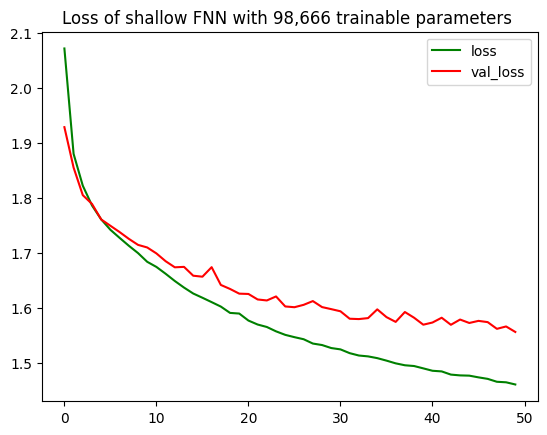

In [7]:
plt.plot(history.history['loss'],color='green')
plt.plot(history.history['val_loss'],color='red')
plt.title(f'Loss of shallow FNN with 98,666 trainable parameters ')
plt.legend(labels=['loss','val_loss'])

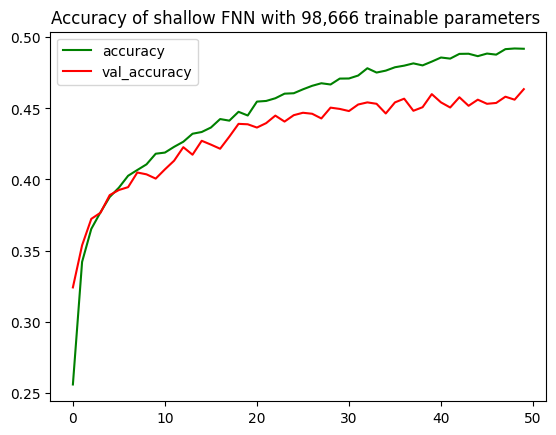

In [8]:
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_accuracy'],color='red')
plt.title(f'Accuracy of shallow FNN with 98,666 trainable parameters ')
plt.legend(labels=['accuracy','val_accuracy'])

In [9]:
fnn_shallow_test_loss, fnn_shallow_test_accuracy = fnn_shallow.evaluate(X_test_flatten, Y_test_orig)
print(f"Test Accuracy: {fnn_shallow_test_accuracy*100:.3f}%")
print(f"Test Loss: {fnn_shallow_test_loss}")

313/313 [==============================] - 1s 3ms/step - loss: 1.5510 - accuracy: 0.4573
Test Accuracy: 45.730%
Test Loss: 1.5509986877441406


Pretty low accuracy on test set with 45.730%

## Deep Feedforward Neural Network + Regularization
Now lets build a deeper model and add regularization (Ridge regularization (L2), Batch Normalization and Dropout)


In [10]:
fnn_deep = tf.keras.models.Sequential([
    tfl.Input(shape=(X_train_flatten.shape[1],)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
fnn_deep.compile(loss=loss, optimizer=optimizer, metrics=metrics)
fnn_deep.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               1573376   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [11]:
history = fnn_deep.fit(X_train_flatten, Y_train,
                  epochs=50,
                  batch_size=64,
                  validation_data=(X_val_flatten, Y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/50
625/625 [==============================] - 10s 7ms/step - loss: 2.6110 - accuracy: 0.2167 - val_loss: 2.0663 - val_accuracy: 0.3145
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 2.2672 - accuracy: 0.2770 - val_loss: 1.9423 - val_accuracy: 0.3608
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 2.1504 - accuracy: 0.3027 - val_loss: 1.8786 - val_accuracy: 0.3779
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 2.0672 - accuracy: 0.3198 - val_loss: 1.9081 - val_accuracy: 0.3675
Epoch 5/50
625/625 [==============================] - 5s 8ms/step - loss: 2.0204 - accuracy: 0.3350 - val_loss: 1.8564 - val_accuracy: 0.3831
Epoch 6/50
625/625 [==============================] - 5s 8ms/step - loss: 1.9786 - accuracy: 0.3428 - val_loss: 1.8920 - val_accuracy: 0.3703
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 1.9352 - accuracy: 0.3537 - val_loss: 1.7729 - val_accuracy: 0.4124
Epoch

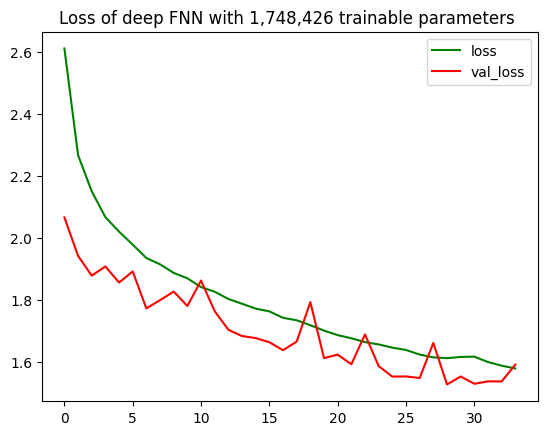

In [12]:
plt.plot(history.history['loss'],color='green')
plt.plot(history.history['val_loss'],color='red')
plt.title(f'Loss of deep FNN with 1,748,426 trainable parameters ')
plt.legend(labels=['loss','val_loss'])

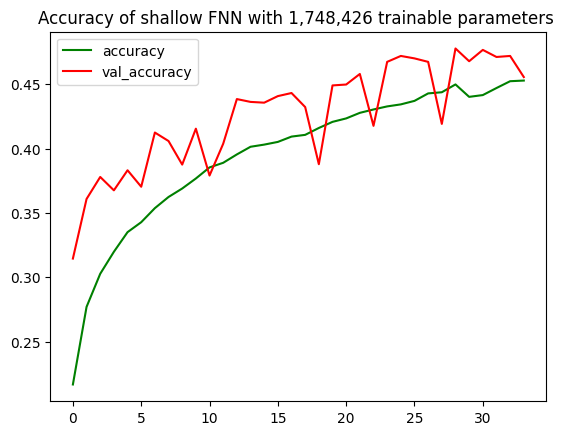

In [13]:
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_accuracy'],color='red')
plt.title(f'Accuracy of shallow FNN with 1,748,426 trainable parameters ')
plt.legend(labels=['accuracy','val_accuracy'])

In [15]:
fnn_deep_test_loss, fnn_deep_test_accuracy = fnn_deep.evaluate(X_test_flatten, Y_test_orig)
print(f"Test Accuracy: {fnn_deep_test_accuracy*100:.3f}%")
print(f"Test Loss: {fnn_deep_test_loss}")

313/313 [==============================] - 1s 3ms/step - loss: 1.5155 - accuracy: 0.4798
Test Accuracy: 47.980%
Test Loss: 1.5154982805252075


It isn't much effective either, with almost 18 times the number of trainable parameters.

## Convolutional Neural Network + Regularization
Finally lets build a deep CNN using regularization (Batch Normalization, Dropout) but with only 551,722 trainable parameters

In [16]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn.compile(optimizer=optimizer,
            loss=loss,
            metrics=metrics)

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                      

In [17]:
history = cnn.fit(X_train, Y_train,
                  epochs=50,
                  batch_size=64,
                  validation_data=(X_val, Y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/50
625/625 [==============================] - 16s 15ms/step - loss: 1.6957 - accuracy: 0.4066 - val_loss: 1.6940 - val_accuracy: 0.3783
Epoch 2/50
625/625 [==============================] - 7s 12ms/step - loss: 1.3079 - accuracy: 0.5322 - val_loss: 1.3681 - val_accuracy: 0.5155
Epoch 3/50
625/625 [==============================] - 8s 12ms/step - loss: 1.1459 - accuracy: 0.5943 - val_loss: 1.3399 - val_accuracy: 0.5434
Epoch 4/50
625/625 [==============================] - 7s 12ms/step - loss: 1.0323 - accuracy: 0.6341 - val_loss: 1.1569 - val_accuracy: 0.5983
Epoch 5/50
625/625 [==============================] - 7s 12ms/step - loss: 0.9379 - accuracy: 0.6719 - val_loss: 1.0130 - val_accuracy: 0.6593
Epoch 6/50
625/625 [==============================] - 7s 12ms/step - loss: 0.8674 - accuracy: 0.6970 - val_loss: 0.9186 - val_accuracy: 0.6768
Epoch 7/50
625/625 [==============================] - 7s 11ms/step - loss: 0.7992 - accuracy: 0.7206 - val_loss: 0.9659 - val_accuracy: 0.657

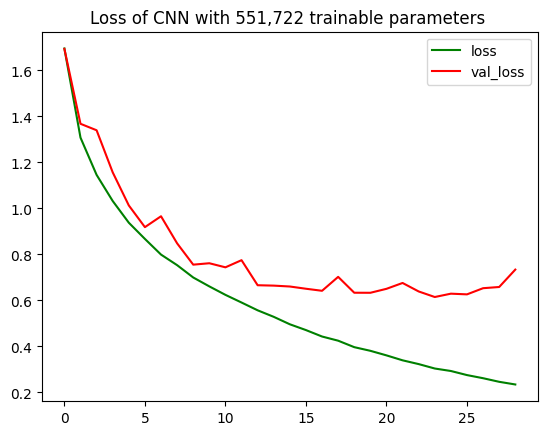

In [18]:
plt.plot(history.history['loss'],color='green')
plt.plot(history.history['val_loss'],color='red')
plt.title(f'Loss of CNN with 551,722 trainable parameters ')
plt.legend(labels=['loss','val_loss'])

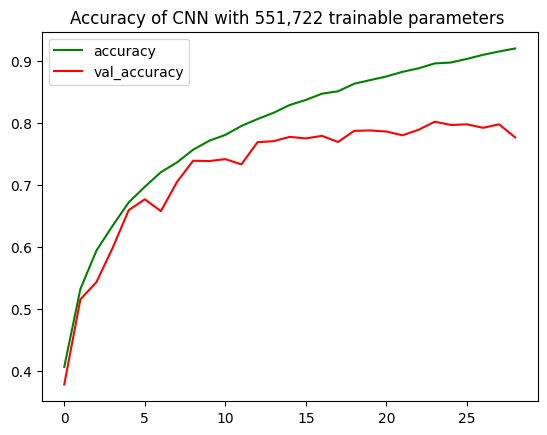

In [19]:
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_accuracy'],color='red')
plt.title(f'Accuracy of CNN with 551,722 trainable parameters ')
plt.legend(labels=['accuracy','val_accuracy'])

In [20]:
cnn_test_loss, cnn_test_accuracy = cnn.evaluate(X_test, Y_test_orig)
print(f"Test Accuracy: {cnn_test_accuracy*100:.3f}%")
print(f"Test Loss: {cnn_test_loss}")

313/313 [==============================] - 1s 3ms/step - loss: 0.6348 - accuracy: 0.7939
Test Accuracy: 79.390%
Test Loss: 0.6347636580467224


CNN achieved a much better performance  with 79.390% accuracy on test set.

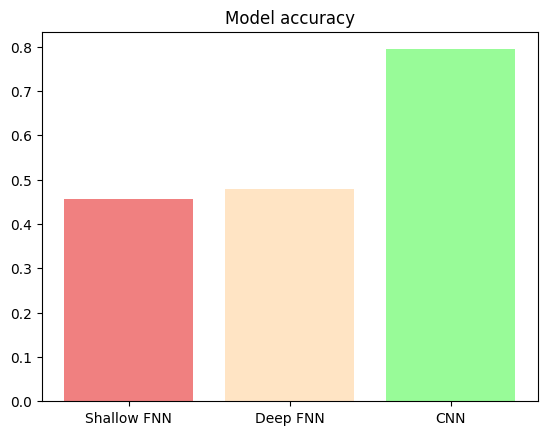

In [21]:
models = ['Shallow FNN','Deep FNN','CNN']
acc_scores = [fnn_shallow_test_accuracy,fnn_deep_test_accuracy,cnn_test_accuracy]
plt.bar(models,acc_scores,color=['lightcoral','bisque','palegreen'])
plt.title('Model accuracy')
plt.show()